In [1]:
import torch
from torch import nn 
import numpy as np
import gym
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import json

C:\Users\boh-b\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\tensorboard\__init__.py:2: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import LooseVersion


In [2]:
class CEM(nn.Module):
    def __init__(self, state_dim, action_n):
        super().__init__()
        self.device = torch.device('cuda')
        self.state_dim = state_dim
        self.action_n = action_n
        
        self.network = nn.Sequential(
            nn.Linear(self.state_dim, 32), 
            nn.ReLU(), 
            nn.Linear(32, 32), 
            nn.ReLU(), 
            nn.Linear(32, self.action_n)
        )
        #self.network.to(self.device)
        
        self.softmax = nn.Softmax()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.012)
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, _input):
        #_input = _input.to(self.device)
        return self.network(_input)
    
    def get_action(self, state, exploration=0):
        state = torch.FloatTensor(state)
        #logits = self.forward(state).to('cpu')
        logits = self.forward(state)
        action_prob = self.softmax(logits).detach().numpy()
        p=(1-exploration)*action_prob+exploration*np.ones(self.action_n)/self.action_n
        if(exploration < 0):
            action = np.argmax(action_prob)
        else:
            action = np.random.choice(self.action_n, p=p/p.sum())
        return action
    
    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        elite_states = torch.FloatTensor(np.array(elite_states))
        #elite_states = elite_states.to(self.device)
        elite_actions = torch.LongTensor(np.array(elite_actions))
        #elite_actions = elite_actions.to(self.device)
        self.optimizer.zero_grad()
        loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()

In [3]:
def get_trajectory(env, agent, trajectory_len, exploration=0, visualize=False):
    trajectory = {'states':[], 'actions': [], 'total_reward': 0}
    
    state = env.reset()
    trajectory['states'].append(state)
    for i in range(trajectory_len):
        with torch.no_grad():
            action = agent.get_action(state, exploration)
        trajectory['actions'].append(action)
        
        state, reward, done, _ = env.step(action)
        trajectory['total_reward'] += reward
        
        if done:
            break
            
        if visualize:
            env.render()
        
        if(i != trajectory_len-1):
            trajectory['states'].append(state)
    
    if visualize:
        print(i,trajectory['total_reward'])  
    return trajectory

In [15]:
def get_elite_trajectories(trajectories, q_param, solved_traj):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param)
    new_solved = [trajectory for trajectory in trajectories if trajectory['total_reward'] >= 200]
    if(len(new_solved)):
        solved_traj.extend(new_solved)
        pass
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] >= quantile]



In [16]:
env = gym.make('LunarLander-v2')
state_dim = 8
action_n = 4
writer = SummaryWriter()
learnin_hist = {'mean_reward': [], 'exploration': [], 'validation': []}

agent = CEM(state_dim, action_n)
#agent = CEM(state_dim, action_n)
#agent.load_state_dict(torch.load('luna3232.model'))

In [17]:
trajectory_len = 400
q_param = 0.8
exploration = 0.9
e_rate = 0.993
solved_traj = []

In [18]:
%%time
episode_n = 2000
trajectory_n = 20

for episode in range(0,episode_n):
    trajectories = [get_trajectory(env, agent, trajectory_len, exploration+0.002) for _ in range(trajectory_n)]
    exploration *= e_rate
    mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
    writer.add_scalar('mtr', mean_total_reward, episode)
    print(f'episode: {episode}, mean_total_reward = {mean_total_reward}')
    elite_trajectories = get_elite_trajectories(trajectories, q_param, solved_traj)
    print('solved =',len(solved_traj),' elite len =',len(elite_trajectories))
    learnin_hist['exploration'].append([episode,mean_total_reward])
    learnin_hist['mean_reward'].append([episode,mean_total_reward])
    if episode%10==0:
        trajectories = [get_trajectory(env, agent, trajectory_len, -1) for _ in range(trajectory_n*3)]
        mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
        if(mean_total_reward>260):
            break
        learnin_hist['validation'].append([episode,mean_total_reward])
        print('validation =', mean_total_reward)
    if len(elite_trajectories) > 0:
        if(len(solved_traj)>0):
            elite_trajectories.append(solved_traj[np.random.randint(len(solved_traj))])
            agent.update_policy(elite_trajectories)
        else:
            agent.update_policy(elite_trajectories)

C:\Users\boh-b\AppData\Local\Temp\ipykernel_22352\2924297689.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_prob = self.softmax(logits).detach().numpy()


episode: 0, mean_total_reward = -177.30705824673927
solved = 0  elite len = 4
validation = -231.60643934735285
episode: 1, mean_total_reward = -164.0789913543372
solved = 0  elite len = 4
episode: 2, mean_total_reward = -219.79432430290177
solved = 0  elite len = 4
episode: 3, mean_total_reward = -207.1874181216677
solved = 0  elite len = 4
episode: 4, mean_total_reward = -237.97041410508655
solved = 0  elite len = 4
episode: 5, mean_total_reward = -169.14782343631595
solved = 0  elite len = 4
episode: 6, mean_total_reward = -139.48504556840444
solved = 0  elite len = 4
episode: 7, mean_total_reward = -203.1622649586921
solved = 0  elite len = 4
episode: 8, mean_total_reward = -176.71485739938245
solved = 0  elite len = 4
episode: 9, mean_total_reward = -183.5631517597113
solved = 0  elite len = 4
episode: 10, mean_total_reward = -190.23436894038764
solved = 0  elite len = 4
validation = -151.30379371014402
episode: 11, mean_total_reward = -175.610731408044
solved = 0  elite len = 4
ep

validation = -97.35486624773586
episode: 101, mean_total_reward = -143.44686457715952
solved = 0  elite len = 4
episode: 102, mean_total_reward = -134.70550527036497
solved = 0  elite len = 4
episode: 103, mean_total_reward = -139.92962803069565
solved = 0  elite len = 4
episode: 104, mean_total_reward = -134.74568465885844
solved = 0  elite len = 4
episode: 105, mean_total_reward = -139.87455924972676
solved = 0  elite len = 4
episode: 106, mean_total_reward = -133.07221641777116
solved = 0  elite len = 4
episode: 107, mean_total_reward = -142.6811014552847
solved = 0  elite len = 4
episode: 108, mean_total_reward = -125.99475909583006
solved = 0  elite len = 4
episode: 109, mean_total_reward = -137.43813457500158
solved = 0  elite len = 4
episode: 110, mean_total_reward = -151.56384716849527
solved = 0  elite len = 4
validation = 28.711928031280397
episode: 111, mean_total_reward = -149.17818578092883
solved = 0  elite len = 4
episode: 112, mean_total_reward = -160.17772433250687
sol

episode: 200, mean_total_reward = -95.77747815676703
solved = 0  elite len = 4
validation = 36.11836460719287
episode: 201, mean_total_reward = -90.74856995177518
solved = 0  elite len = 4
episode: 202, mean_total_reward = -93.79458593846155
solved = 0  elite len = 4
episode: 203, mean_total_reward = -93.22420582585772
solved = 0  elite len = 4
episode: 204, mean_total_reward = -90.2589001523298
solved = 0  elite len = 4
episode: 205, mean_total_reward = -91.05830531705861
solved = 0  elite len = 4
episode: 206, mean_total_reward = -86.66638675108818
solved = 0  elite len = 4
episode: 207, mean_total_reward = -118.69378508448983
solved = 0  elite len = 4
episode: 208, mean_total_reward = -85.13957586040125
solved = 0  elite len = 4
episode: 209, mean_total_reward = -102.59099259640288
solved = 0  elite len = 4
episode: 210, mean_total_reward = -131.18360910670137
solved = 0  elite len = 4
validation = -217.61959722832006
episode: 211, mean_total_reward = -149.97070596941532
solved = 0 

episode: 299, mean_total_reward = -132.968562344384
solved = 0  elite len = 4
episode: 300, mean_total_reward = -104.46081977020876
solved = 0  elite len = 4
validation = -84.39824241629508
episode: 301, mean_total_reward = -106.71361516161744
solved = 0  elite len = 4
episode: 302, mean_total_reward = -92.45273026441079
solved = 0  elite len = 4
episode: 303, mean_total_reward = -128.29002144124712
solved = 0  elite len = 4
episode: 304, mean_total_reward = -120.08452349294514
solved = 0  elite len = 4
episode: 305, mean_total_reward = -84.25773083846124
solved = 0  elite len = 4
episode: 306, mean_total_reward = -102.10671287744702
solved = 0  elite len = 4
episode: 307, mean_total_reward = -111.85790371089051
solved = 0  elite len = 4
episode: 308, mean_total_reward = -130.60223881059196
solved = 0  elite len = 4
episode: 309, mean_total_reward = -124.39944778846527
solved = 0  elite len = 4
episode: 310, mean_total_reward = -89.22200284654397
solved = 0  elite len = 4
validation = 

episode: 399, mean_total_reward = -16.80872014346797
solved = 0  elite len = 4
episode: 400, mean_total_reward = -23.212896845955992
solved = 0  elite len = 4
validation = -54.975228011419176
episode: 401, mean_total_reward = -15.960632402095646
solved = 0  elite len = 4
episode: 402, mean_total_reward = -13.203779730731387
solved = 0  elite len = 4
episode: 403, mean_total_reward = 3.057093223225267
solved = 0  elite len = 4
episode: 404, mean_total_reward = -10.35176336971262
solved = 0  elite len = 4
episode: 405, mean_total_reward = -14.772689408612766
solved = 0  elite len = 4
episode: 406, mean_total_reward = -47.118982265134115
solved = 0  elite len = 4
episode: 407, mean_total_reward = 3.209564535500564
solved = 0  elite len = 4
episode: 408, mean_total_reward = 2.2454083208938265
solved = 0  elite len = 4
episode: 409, mean_total_reward = -2.698469737705495
solved = 0  elite len = 4
episode: 410, mean_total_reward = 19.015501828934276
solved = 0  elite len = 4
validation = 23.

episode: 500, mean_total_reward = 61.14620057004133
solved = 1  elite len = 4
validation = 79.7574856609542
episode: 501, mean_total_reward = 63.80596562317934
solved = 1  elite len = 4
episode: 502, mean_total_reward = 78.05086925200065
solved = 1  elite len = 4
episode: 503, mean_total_reward = 63.72848135465496
solved = 1  elite len = 4
episode: 504, mean_total_reward = 79.68687908531126
solved = 1  elite len = 4
episode: 505, mean_total_reward = 85.19696764839281
solved = 1  elite len = 4
episode: 506, mean_total_reward = 64.44510728497936
solved = 1  elite len = 4
episode: 507, mean_total_reward = 98.10373953552683
solved = 1  elite len = 4
episode: 508, mean_total_reward = 48.28384669939386
solved = 1  elite len = 4
episode: 509, mean_total_reward = 76.75463831781761
solved = 1  elite len = 4
episode: 510, mean_total_reward = 97.8016562247653
solved = 1  elite len = 4
validation = 82.71544643505945
episode: 511, mean_total_reward = 44.378670673191195
solved = 1  elite len = 4
epi

episode: 601, mean_total_reward = 73.36500372353386
solved = 3  elite len = 4
episode: 602, mean_total_reward = 94.98647822905437
solved = 3  elite len = 4
episode: 603, mean_total_reward = 81.90738281063683
solved = 3  elite len = 4
episode: 604, mean_total_reward = 101.37559427231815
solved = 3  elite len = 4
episode: 605, mean_total_reward = 100.21150943597141
solved = 3  elite len = 4
episode: 606, mean_total_reward = 81.26165918614984
solved = 3  elite len = 4
episode: 607, mean_total_reward = 89.56215520599832
solved = 3  elite len = 4
episode: 608, mean_total_reward = 98.26962153341736
solved = 3  elite len = 4
episode: 609, mean_total_reward = 82.97919331948472
solved = 3  elite len = 4
episode: 610, mean_total_reward = 103.3790983821292
solved = 3  elite len = 4
validation = 146.9172485482168
episode: 611, mean_total_reward = 71.52635283040394
solved = 3  elite len = 4
episode: 612, mean_total_reward = 96.56092460267357
solved = 3  elite len = 4
episode: 613, mean_total_reward

episode: 702, mean_total_reward = 122.5813016457904
solved = 5  elite len = 4
episode: 703, mean_total_reward = 115.23618220669314
solved = 5  elite len = 4
episode: 704, mean_total_reward = 128.075395346078
solved = 5  elite len = 4
episode: 705, mean_total_reward = 75.58737168550707
solved = 5  elite len = 4
episode: 706, mean_total_reward = 90.88489792771342
solved = 6  elite len = 4
episode: 707, mean_total_reward = 96.63626487156014
solved = 6  elite len = 4
episode: 708, mean_total_reward = 88.8020915486394
solved = 6  elite len = 4
episode: 709, mean_total_reward = 33.76903091698332
solved = 6  elite len = 4
episode: 710, mean_total_reward = 54.796237141489385
solved = 6  elite len = 4
validation = 151.4566109403659
episode: 711, mean_total_reward = 75.70125117753129
solved = 6  elite len = 4
episode: 712, mean_total_reward = 111.09053846195711
solved = 6  elite len = 4
episode: 713, mean_total_reward = 87.31824762044735
solved = 6  elite len = 4
episode: 714, mean_total_reward 

episode: 803, mean_total_reward = 113.39177429330111
solved = 10  elite len = 4
episode: 804, mean_total_reward = 139.6534882145824
solved = 10  elite len = 4
episode: 805, mean_total_reward = 101.47047122764869
solved = 10  elite len = 4
episode: 806, mean_total_reward = 121.897440217351
solved = 10  elite len = 4
episode: 807, mean_total_reward = 101.79163396591639
solved = 11  elite len = 4
episode: 808, mean_total_reward = 89.42653166689595
solved = 11  elite len = 4
episode: 809, mean_total_reward = 106.01409481688793
solved = 12  elite len = 4
episode: 810, mean_total_reward = 113.21395356650225
solved = 12  elite len = 4
validation = 228.86215479353368
episode: 811, mean_total_reward = 120.11437682272458
solved = 12  elite len = 4
episode: 812, mean_total_reward = 87.38475720511077
solved = 12  elite len = 4
episode: 813, mean_total_reward = 92.59752124750138
solved = 12  elite len = 4
episode: 814, mean_total_reward = 84.32826639472367
solved = 13  elite len = 4
episode: 815, m

KeyboardInterrupt: 

In [44]:
get_trajectory(env, agent, 4000, exploration=-1,visualize=True)
print()

C:\Users\boh-b\AppData\Local\Temp\ipykernel_11524\2924297689.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_prob = self.softmax(logits).detach().numpy()


261 232.8996827159056



In [68]:
torch.save(agent.state_dict(), 'luna3232_best.model')

In [59]:
model = CEM(state_dim, action_n)
model.load_state_dict(torch.load('luna3232_best.model'))
model.eval()

CEM(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=None)
  (loss): CrossEntropyLoss()
)

In [33]:
trajectories = [get_trajectory(env, agent, 400,-1) for _ in range(100)]
mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
mean_total_reward

C:\Users\boh-b\AppData\Local\Temp\ipykernel_11524\2924297689.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_prob = self.softmax(logits).detach().numpy()


267.44947532570393

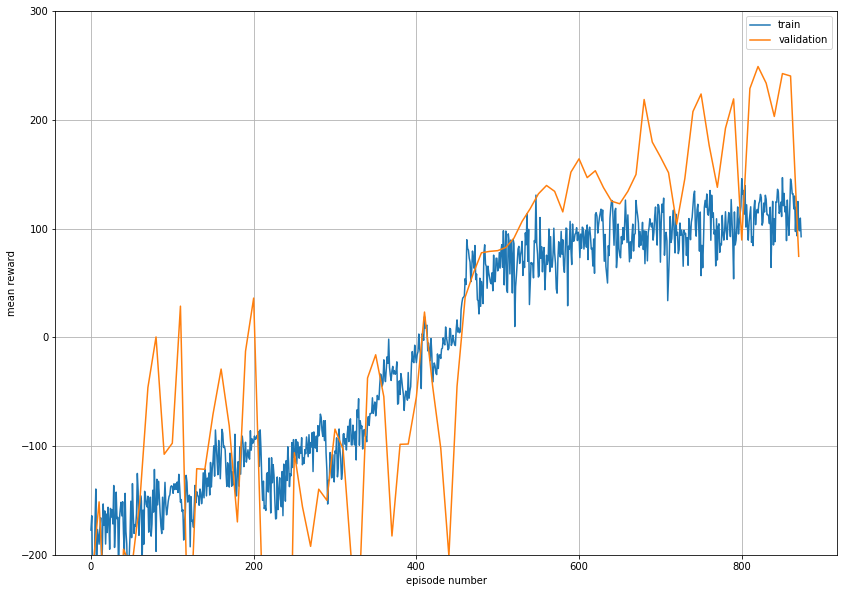

In [19]:
plt.figure(figsize=[14,10])
plt.plot(np.array(learnin_hist['mean_reward'])[:,0],np.array(learnin_hist['mean_reward'])[:,1],label='train')
plt.plot(np.array(learnin_hist['validation'])[:,0],np.array(learnin_hist['validation'])[:,1],label='validation')
plt.grid(True)
plt.ylim([-200,300])
plt.xlabel('episode number')
plt.ylabel('mean reward')
plt.legend()
plt.savefig('train.png',dpi=300,bbox_inches='tight',facecolor='white')

In [30]:
ep_l = (np.array(learnin_hist['mean_reward'])[:,0])
ep_v = (np.array(learnin_hist['validation'])[:,0])
l_r = (np.array(learnin_hist['mean_reward'])[:,1])
v_r = (np.array(learnin_hist['validation'])[:,1])

In [32]:
np.savetxt('ce_l.txt',np.array([ep_l,l_r]).T)
np.savetxt('ce_v.txt',np.array([ep_v,v_r]).T)